In [1]:
import matplotlib.pyplot as plt
import glob
import pickle
from keras.utils import to_categorical

from pkl_reader import *
from lstm_impl import CombinedLSTM

Using TensorFlow backend.
/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
# The function to extract training data from snippets pickles
def extract_data(pklfile, full_traj=False):
    with open(pklfile, 'rb') as f:
        dataset_all = pickle.load(f)
        
    # All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    history_traj_data = np.array(dataset_all['features'])[:, :, :]

    # All the future trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    future_traj_data = np.array(dataset_all['labels'])[:, :, :-1]

    # All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
    goals_position = np.array(dataset_all['goals'])
    goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

    # All intention labels, with shape (batch_size, goal_nums)
    goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
    # Convert to one-hot and the last one is undecided (-1)
    one_hot_goal = to_categorical(goal_idx, num_classes=33)
    
    if full_traj:
        traj_idx = np.array(dataset_all['traj_idx'])
        return history_traj_data, future_traj_data, goals_position, one_hot_goal, traj_idx
    else:  
        return history_traj_data, future_traj_data, goals_position, one_hot_goal

In [3]:
# Get the data
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

pklfile = pklfiles_to_process[file_num]

test_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

test_set['history_traj_data'], test_set['future_traj_data'], test_set['goal_position'], test_set['one_hot_goal'], traj_idx = extract_data(pklfile, full_traj=True)

Found 6 pkl files: ['./dataset/pilot_dataset_12_08_13_02_29.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_0.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_1.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_2.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_3.pkl', './dataset/pilot_dataset_12_08_13_02_29_fold_4.pkl']


In [4]:
# Build the model
history_shape = test_set['history_traj_data'].shape
goals_position_shape = test_set['goal_position'].shape
one_hot_goal_shape = test_set['one_hot_goal'].shape
future_shape = test_set['future_traj_data'].shape
hidden_dim = 100
comb_lstm = CombinedLSTM(history_shape, goals_position_shape, one_hot_goal_shape, future_shape, hidden_dim)
# comb_lstm.load('file_name')
# comb_lstm.goal_model.load()
# comb_lstm.traj_model.load()

In [ ]:
comb_lstm.fit(test_set, test_set)

In [ ]:
comb_lstm.goal_model.save_model()
comb_lstm.traj_model.save_model()

In [5]:
# Load the model
models_on_disk = glob.glob('./model/goal_model_*.h5')
models_on_disk.sort()
print('Found %d model files: %s' % (len(models_on_disk), models_on_disk))

Found 2 model files: ['./model/goal_model_0.8928_12_08_15_22.h5', './model/goal_model_0.9485_12_04_13_26.h5']


In [6]:
comb_lstm.goal_model.load()
comb_lstm.traj_model.load()

Goal Model files on disk: ['./model/goal_model_0.8928_12_08_15_22.h5', './model/goal_model_0.9485_12_04_13_26.h5']
Traj Model files on disk: ['./model/traj_model_0.7102_12_08_15_22.h5', './model/traj_model_0.9244_12_04_14_20.h5']


In [7]:
goal_pred, traj_pred = comb_lstm.predict(test_set)

In [ ]:
print(goal_pred)
print(len(goal_pred))
print(traj_idx)

/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


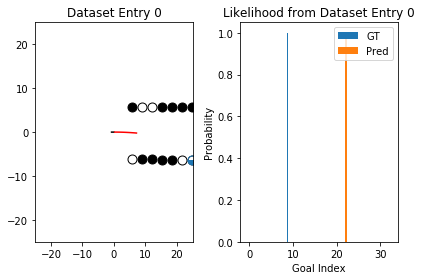

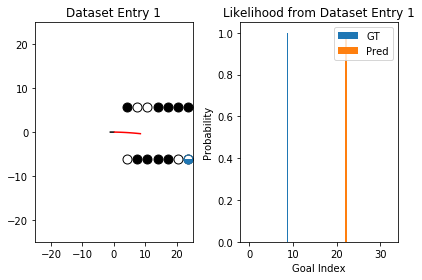

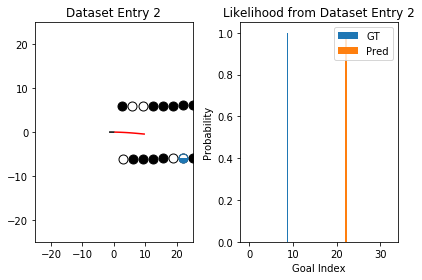

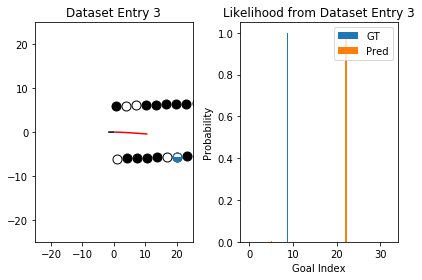

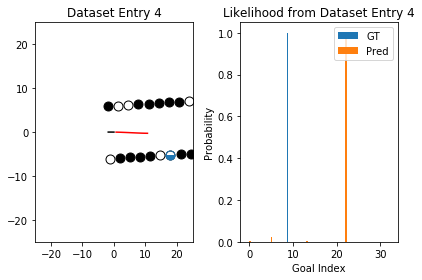

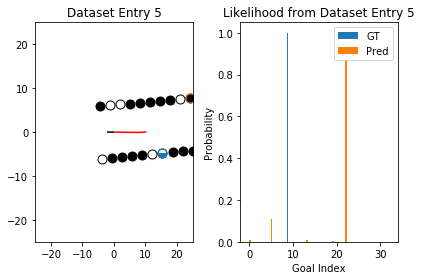

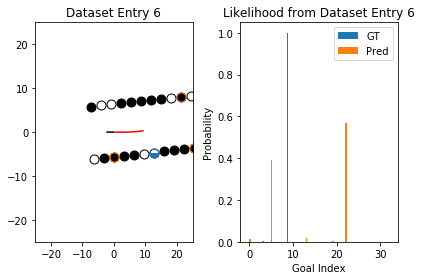

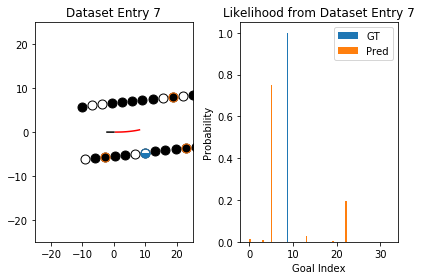

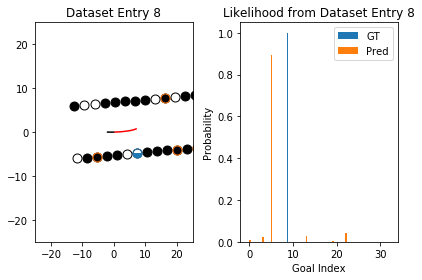

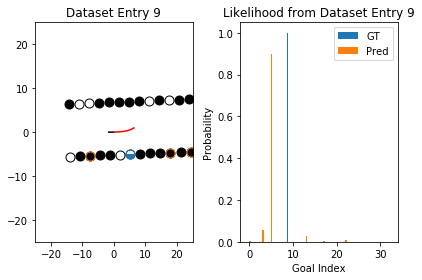

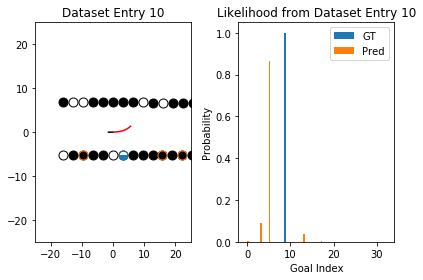

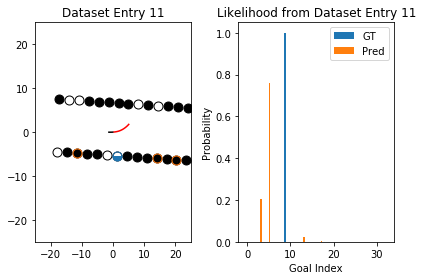

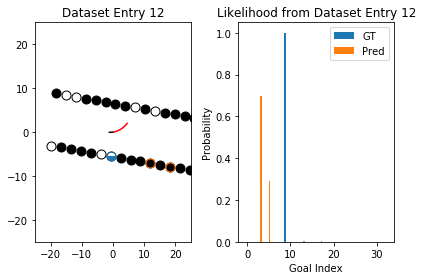

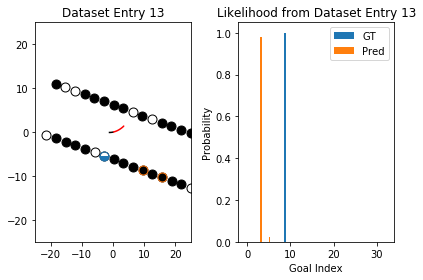

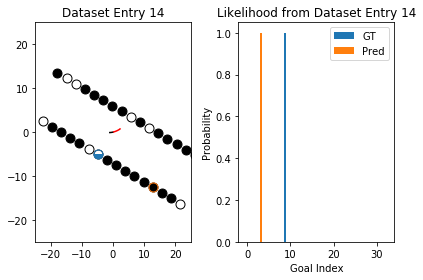

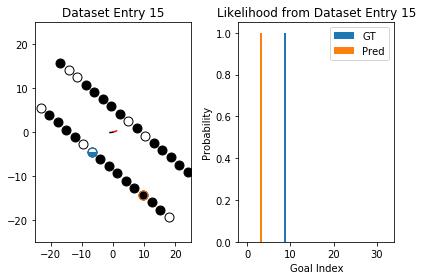

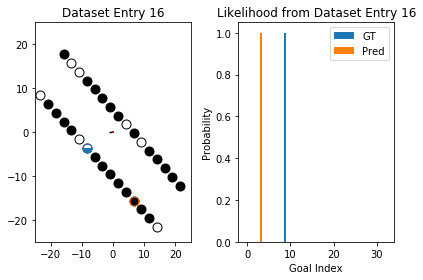

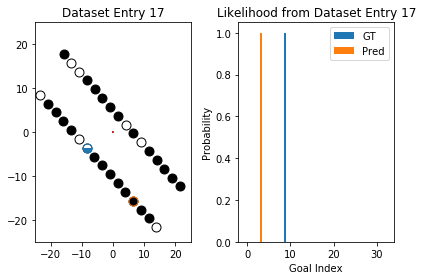

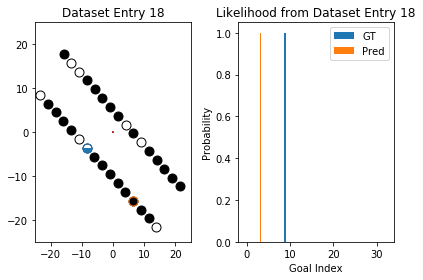

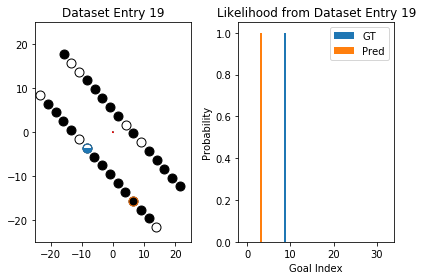

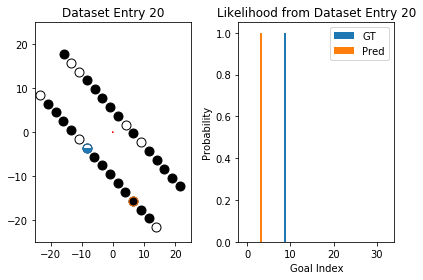

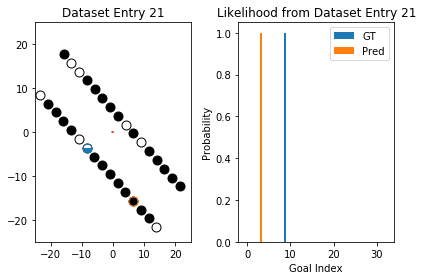

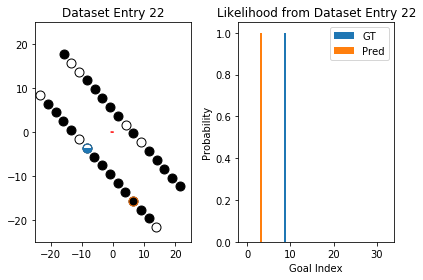

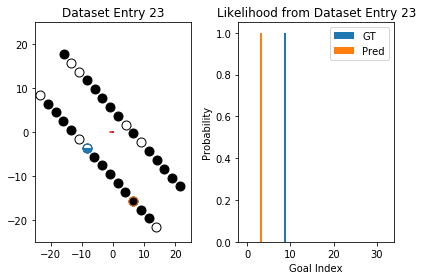

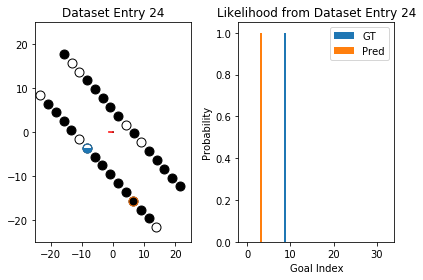

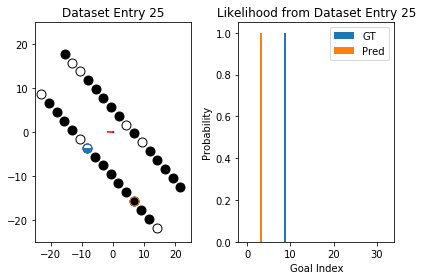

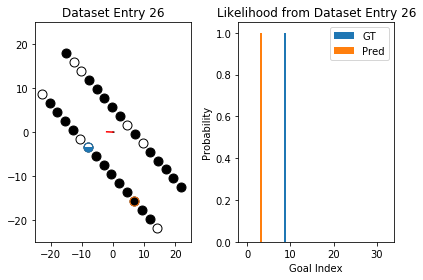

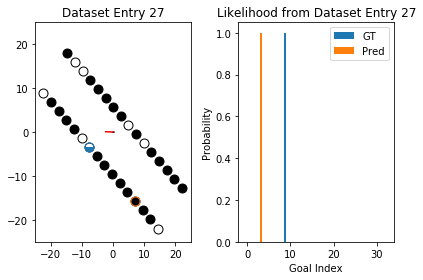

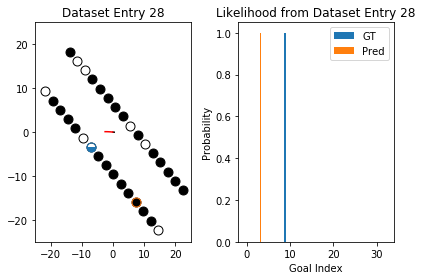

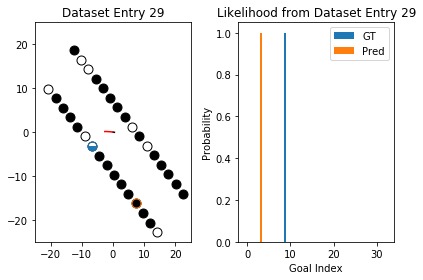

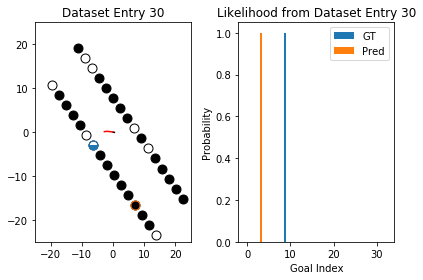

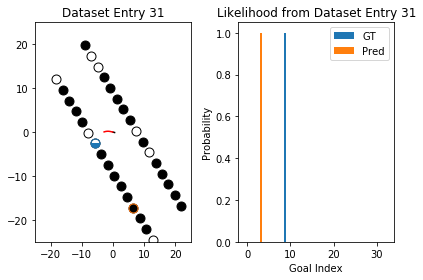

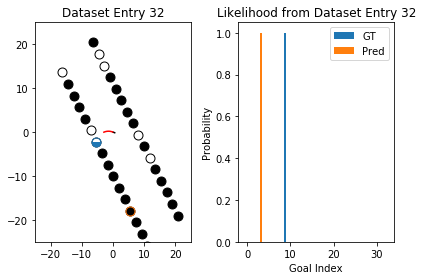

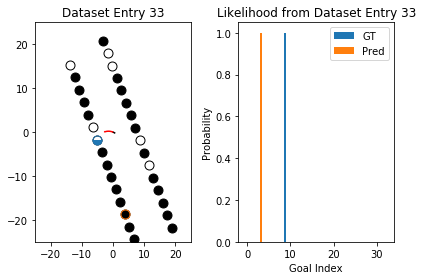

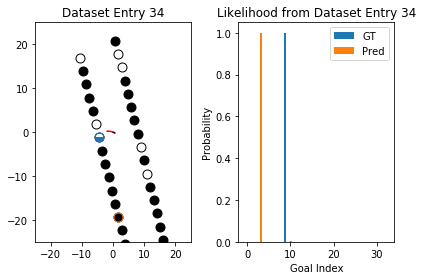

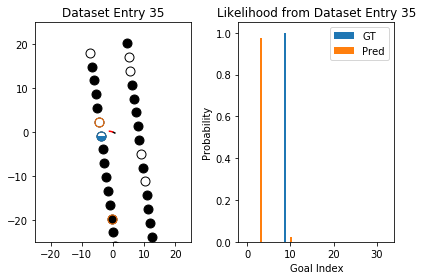

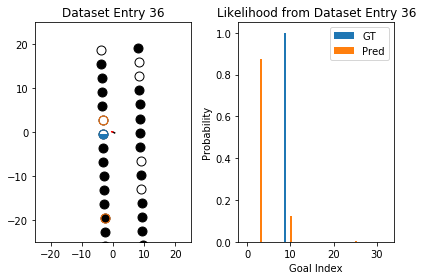

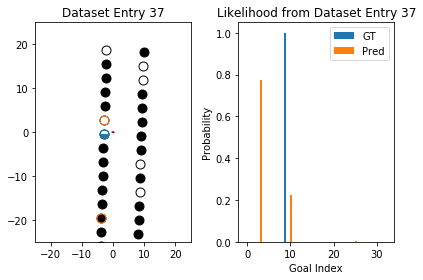

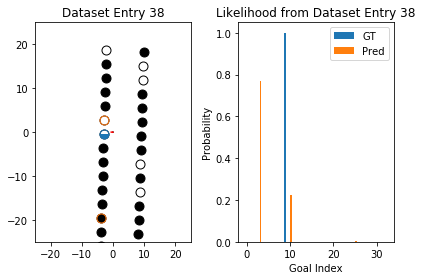

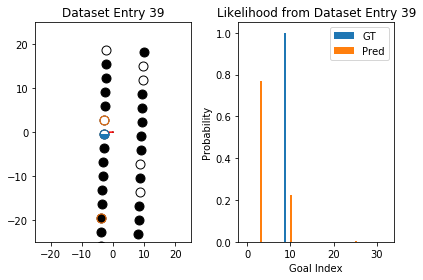

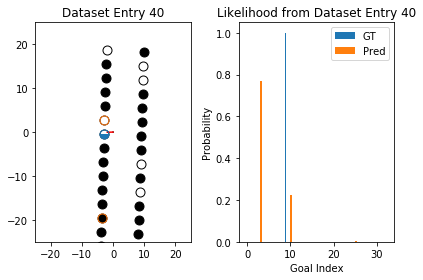

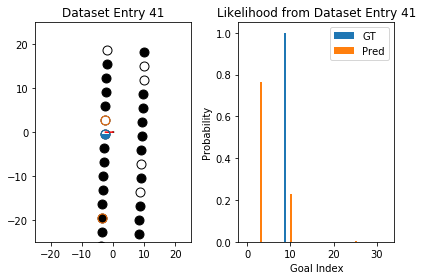

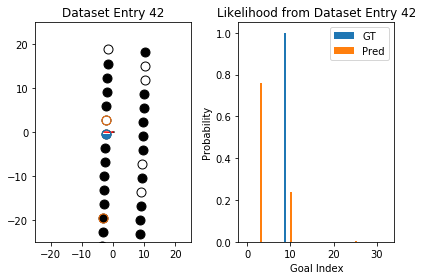

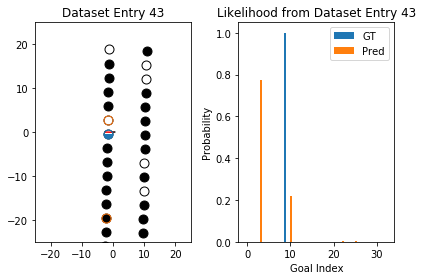

In [13]:
# for i in range(len(traj_idx) - 1):
import matplotlib.animation as manimation
import numpy as np

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

start_idx = traj_idx[0]
end_idx   = traj_idx[1]

# Plot the result
goal_ind = np.arange(33)
bar_width = 0.35
# Recover the goal coordinates
test_goals_coords = test_set['goal_position'].reshape((test_set['goal_position'].shape[0], 32, 3))
test_hist_traj    = test_set['history_traj_data']
test_future_traj  = test_set['future_traj_data']
test_one_hot_goal = test_set['one_hot_goal']

for i in range(start_idx, end_idx):
    plt.figure()
    plt.subplot(121)
    
    current = test_hist_traj[i][-1, :].copy()
    th = current[2]
    R = np.array([[ np.cos(th), np.sin(th)], \
                  [-np.sin(th), np.cos(th)]])
    Rinv = np.linalg.inv(R)
    
    # Plot the vehicle trajectory in the snippet
    test_hist_traj_rot = (Rinv @ test_hist_traj[i][:,:2].T).T
    test_future_traj_rot = (Rinv @ test_future_traj[i][:,:2].T).T
    plt.plot(test_hist_traj_rot[:,0], test_hist_traj_rot[:,1], 'k')
    plt.plot(test_future_traj_rot[:,0], test_future_traj_rot[:,1], 'r')
    
    # Plot the occupancy in the snippet
    test_goals_coords_rot = (Rinv @ test_goals_coords[i][:,:2].T).T
    for goal, occup in zip(test_goals_coords_rot, test_goals_coords[i]):
        if occup[2] > 0:
            plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
        else:
            plt.plot(goal[0], goal[1], 'ko', markersize = 9)
    
    # Get the ground truth intention
    gt_idx = np.argmax(test_one_hot_goal[i])
    # Predictions above a threshold
    thres = 1e-2
    best_k_idx = [k for k, p in enumerate(goal_pred[i]) if p >= thres]
    if gt_idx == 32: # If it is "-1" -> undetermined 
        plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    else:
        plt.plot(test_goals_coords_rot[gt_idx][0], test_goals_coords_rot[gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)
    
    for j in best_k_idx:
        if j == 32:
            plt.plot(0, 0, 'v', fillstyle='none', color = '#ff770e', markersize = 9)
        else:
            plt.plot(test_goals_coords_rot[j][0], test_goals_coords_rot[j][1], 'o', fillstyle='none', color = '#ff770e', markersize = 9)
            
    plt.title('Dataset Entry %d' % i)
    plt.xlim([-25, 25])
    plt.ylim([-25, 25])
    
    plt.subplot(122)
    p1 = plt.bar(goal_ind - bar_width/2, test_one_hot_goal[i], bar_width, label='GT')
    p2 = plt.bar(goal_ind + bar_width/2, goal_pred[i], bar_width, label='Pred')
    plt.xlabel('Goal Index')
    plt.ylabel('Probability')
    plt.title('Likelihood from Dataset Entry %d' % i)
    plt.legend()
    plt.tight_layout()

In [ ]:
test_goals_coords.shape